# Scalar Bilevel ROF Single Gaussian SMILEY
We will solve the following bilevel problem

$$
\min_\lambda \|\hat{u}-z\|^2 + \beta\lambda^2\\
\text{s.t. } \hat{u} = arg\min_u \frac{1}{2}\|u-f\|^2+\lambda\|\mathbb{K} u\|_{2,1} 
$$

We will use a small dataset of one sample contaminated with gaussian noise to learn the optimal parameter for the ROF image denoising model.

In [1]:
include("../../src/BilevelImagingParameterLearning.jl")
using .BilevelImagingParameterLearning

In [2]:
using LinearAlgebra, StructuredOptimization, AbstractOperators, Plots, Distributed, Images, ImageQualityIndexes, JLD

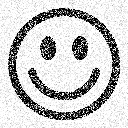

In [3]:
# Noisy image
f = datasetimage("1_smiley_noisy","../../src/datasets/smiley_dataset")
f[f .< 0] .= 0. # Make sure pixels are in range
f[f .> 1] .= 1.
Gray.(f)

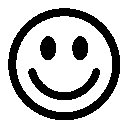

In [9]:
# Ground truth
z = datasetimage("1_smiley_original","../../src/datasets/smiley_dataset")
z[z .< 0] .= 0. # Make sure pixels are in range
z[z .> 1] .= 1.
Gray.(z)

In [10]:
println("SSIM: ",ssim(f,z))
println("PSNR: ",psnr(f,z))

SSIM: 0.41487045600825345
PSNR: 13.07757184046984


## Bilevel Cost Function
First, we will plot the cost function to see the form it has for this particular problem

In [6]:
# Lower Level Solver
function lower_level_solver(u,f,λ,K)
    @minimize ls(-K'*u+f) + conj(λ*norm(u,2,1,2)) with ForwardBackward(tol = 1e-3, gamma = 1/8, fast = true) 
    return -K'*(~u)+f
end

# Upper level cost
function upper_level_cost(u,z,λ,α)
    return 0.5*norm(u[:]-z[:])^2 + 0.5*α*norm(λ)^2
end

upper_level_cost (generic function with 1 method)

In [29]:
K = Variation(size(f)) # Define the finite differences gradient operator
u = Variable(size(K,1)...)
α = 0.01;

In [43]:
step = 0.01
lambda_max = 4.0
lambda_min = eps()
lambda_range = lambda_min:step:lambda_max
costs = Float64[]
ssims = Float64[]
@distributed for λ in lambda_range
    u_h = lower_level_solver(u,f,λ,K)
    push!(costs,upper_level_cost(u_h,z,λ,α))
    push!(ssims,ssim(u_h,z))
    #println("$λ $costs")
end
println("done")

done


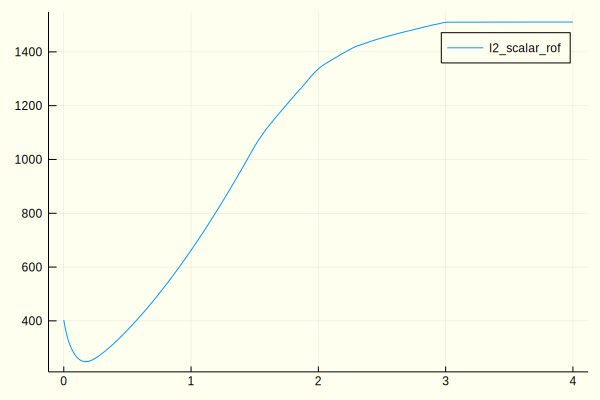

In [44]:
plot(lambda_range,costs,label="l2_scalar_rof", background_color = :ivory)

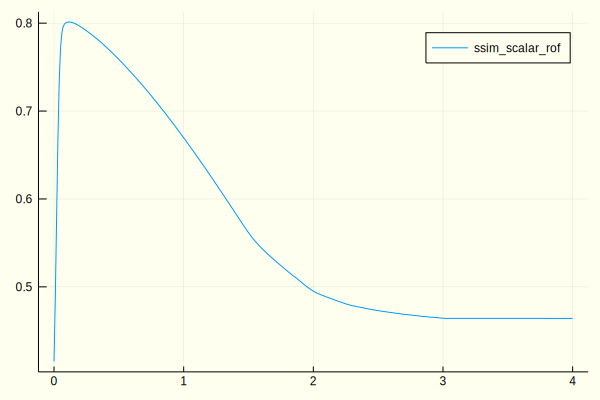

In [45]:
plot(lambda_range,ssims,label="ssim_scalar_rof", background_color = :ivory)

In [11]:
# Saving generated data
using JLD
save("smiley_scalar_rof_cost.jld", "lambda", lambda_range, "costs", costs, "ssims",ssims)

## Gradient Calculation

In [46]:
include("gradient_solver.jl")

gradient_solver (generic function with 1 method)

In [49]:
∇ = gradient_matrix(size(f))
step = 0.1
lambda_max = 4.0
lambda_min = eps()
lambda_range = lambda_min:step:lambda_max
grads = Float64[]
@distributed for λ in lambda_range
    u_h = lower_level_solver(u,f,λ,K)
    g = gradient_solver(u_h,z,λ,α,K,∇)
    push!(grads,g)
    println("$λ -> $g")
end
println("done")

done
2.220446049250313e-16 -> -3013.8176534965655
0.10000000000000023 -> -183.24156292486583
0.20000000000000023 -> 181.38012084522222
0.30000000000000027 -> 247.70965028968445
0.40000000000000024 -> 265.4521837858641
0.5000000000000002 -> 272.58131244862864
0.6000000000000003 -> 275.65238783079724
0.7000000000000003 -> 278.2359616124984
0.8000000000000003 -> 278.6946534211025
0.9000000000000002 -> 277.0131097228742
1.0000000000000002 -> 271.4372638829011
1.1000000000000003 -> 263.3489612458585
1.2000000000000004 -> 249.62589842000963
1.3000000000000003 -> 233.0433089174074
1.4000000000000004 -> 209.3324321939592
1.5000000000000002 -> 172.44509007176168
1.6000000000000003 -> 144.30064824245852
1.7000000000000004 -> 129.8667044153126
1.8000000000000003 -> 113.12691422033315
1.9000000000000004 -> 87.8404910689652
2.0 -> 59.242957345569124
2.1000000000000005 -> 50.87900995098856
2.2 -> 42.75686058374226
2.3000000000000007 -> 35.31613104394547
2.4000000000000004 -> 30.555288429243436
2.5 -

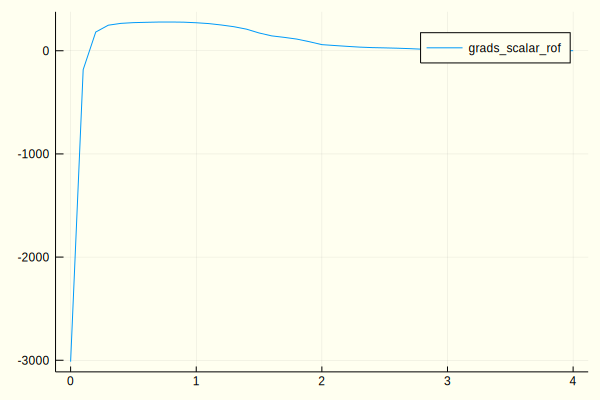

In [50]:
plot(lambda_range,grads,label="grads_scalar_rof", background_color = :ivory)

## Solving Bilevel Problem
We will define a numerical strategy based on an inexact Trust Region method to solve the bilevel problem. First, we need to define a gradient calculation

In [63]:
include("trust_region_solver.jl")

trust_region_solver (generic function with 3 methods)

In [67]:
lambda_0 = 0.09
radius_0 = 1
tol = 1e-5
lambda_opt = trust_region_solver(lower_level_solver,upper_level_cost,1,f,z,radius_0,tol)

TR Iteration 1: rho_k = 0.9552235261616342, radius = 1.5, lambda = 2.2123177512156644e-8
TR Iteration 2: rho_k = -0.3243623014080297, radius = 0.75, lambda = 2.2123177512156644e-8
TR Iteration 3: rho_k = -0.09912794678894393, radius = 0.375, lambda = 2.2123177512156644e-8
TR Iteration 4: rho_k = 0.1914067095128207, radius = 0.375, lambda = 0.37500001647861775
TR Iteration 5: rho_k = -0.963641055871418, radius = 0.1875, lambda = 0.37500001647861775
TR Iteration 6: rho_k = 1.1960597522390148, radius = 0.28125, lambda = 0.18750002062671337
TR Iteration 7: rho_k = -5.219041162582921, radius = 0.140625, lambda = 0.18750002062671337
TR Iteration 8: rho_k = -2.852820950140342, radius = 0.0703125, lambda = 0.18750002062671337
TR Iteration 9: rho_k = -0.8449607458616186, radius = 0.03515625, lambda = 0.18750002062671337
TR Iteration 10: rho_k = -0.08750885549853597, radius = 0.017578125, lambda = 0.18750002062671337
TR Iteration 11: rho_k = 0.24072641606239534, radius = 0.017578125, lambda = 0.

0.16992189601559712

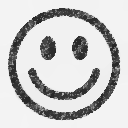

In [68]:
u_opt = lower_level_solver(u,f,lambda_opt,K)
Gray.(u_opt)

In [69]:
println(ssim(u_opt,z))
println(ssim(f,z))

0.7989319117122737
0.41487045600825345


In [70]:
println(psnr(u_opt,z))
println(psnr(f,z))

15.184803851180742
13.07757184046984
